####  STATISTICAL TECHNIQUES FOR NOISY DATA - Challenge QRT 2020
---

#### Challenge Context

Quantitative investment strategies require the analysis of historical data to predict the trend of a stock in a near future. However, the extremely low level of signal / noise makes it a very challenging problem. Digging slight information among the enormous amount of available data in the market is a key goal for Qube RT. To do so, Machine Learning techniques can be used to make better trading decisions through deep analysis of thousands of different data sources. In a financial world in constant movement, it is extremely difficult to detect patterns that make a stock move up or down. This challenge is an illustration of the financial stock prediction.



#### Challenge Goal

The proposed challenge aims at predicting the return of a stock in the US market using historical data over a recent period of 20 days.

In this challenge, we consider the residual stock return, which corresponds to the return of a stock without the market impact. Historical data are composed of residual stock returns and relative volumes, sampled each day during the 20 last business days (approximately one month).

The metric considered is the accuracy of the predicted residual stock return sign.

##### 1. Libraries set up 


In [36]:
# Libraries

# Standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import os 

# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt
# Plot settings
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = [8.0, 4.0]
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['lines.linewidth'] = 2.0

# ML libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#### 2. Data
2.1 Data Loading

In [2]:
X_train = pd.read_csv("./data et benchmark/x_train_Lafd4AH.csv", index_col='ID')
X_test = pd.read_csv("./data et benchmark/x_test_c7ETL4q.csv", index_col='ID')
y_train = pd.read_csv("./data et benchmark/y_train_JQU4vbI.csv", index_col='ID')

X_train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.059459,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,0.015413,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,0.008964,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,-0.031769,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.038461,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806


So each row of our datasets is composed of stock, some information about its sector and it's historical residual return over an historic of 20 days. And information of the Volume exchange of this stock over each day of the historical period considered here.

In [3]:
y_train.head()

,RET
ID,
0,True
1,True
2,False
3,False
4,False


The target of this challenge is RET and corresponds to the fact that **the return is in the top 50% of highest stock returns.**

Since the median(50%) is very close to 0, this information should not change much with the idea to predict the sign of the return. 

2.2 Data Analysis and Exploratory

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418595 entries, 0 to 418594
Data columns (total 46 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            418595 non-null  int64  
 1   STOCK           418595 non-null  int64  
 2   INDUSTRY        418595 non-null  int64  
 3   INDUSTRY_GROUP  418595 non-null  int64  
 4   SECTOR          418595 non-null  int64  
 5   SUB_INDUSTRY    418595 non-null  int64  
 6   RET_1           416236 non-null  float64
 7   VOLUME_1        353570 non-null  float64
 8   RET_2           416130 non-null  float64
 9   VOLUME_2        352209 non-null  float64
 10  RET_3           416088 non-null  float64
 11  VOLUME_3        350776 non-null  float64
 12  RET_4           416051 non-null  float64
 13  VOLUME_4        347598 non-null  float64
 14  RET_5           416011 non-null  float64
 15  VOLUME_5        343902 non-null  float64
 16  RET_6           415998 non-null  float64
 17  VOLUME_6       

We notice that the non-null count is inconsistent throughout the features. Let's look at the NaN values.

In [5]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418595 entries, 0 to 418594
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   RET     418595 non-null  bool 
dtypes: bool(1)
memory usage: 3.6 MB


So The dataset is made of 46 descriptive features:

. DATE: an index of the date (the dates are randomized and anonymized so there is no continuity or link between any dates no way to treat our problem as a time series problem),

. STOCK: an index of the stock,

. INDUSTRY: an index of the stock industry domain (e.g., aeronautic, IT, oil company),

. INDUSTRY_GROUP: an index of the group industry,

. SUB_INDUSTRY: a lower level index of the industry,

. SECTOR: an index of the work sector,

. RET_1 to RET_20: the historical residual returns among the last 20 days (i.e., RET_1 is the return of the previous day and so on),

. VOLUME_1 to VOLUME_20: the historical relative volume traded among the last 20 days (i.e., VOLUME_1 is the relative volume of the previous day and so on)

And 1 target variable:

. RET: True if the stock return is in the top 50% of highest stock returns

Moreover, we notice that the non-null count is inconsistent throughout the features. Let's look at the NaN values.

**NAN Values**

In [6]:
X_train.isna().sum()

DATE                  0
STOCK                 0
INDUSTRY              0
INDUSTRY_GROUP        0
SECTOR                0
SUB_INDUSTRY          0
RET_1              2359
VOLUME_1          65025
RET_2              2465
VOLUME_2          66386
RET_3              2507
VOLUME_3          67819
RET_4              2544
VOLUME_4          70997
RET_5              2584
VOLUME_5          74693
RET_6              2597
VOLUME_6          74714
RET_7              2585
VOLUME_7          73853
RET_8              2623
VOLUME_8          73898
RET_9              2682
VOLUME_9          73298
RET_10             2692
VOLUME_10         73305
RET_11             2961
VOLUME_11         72025
RET_12             3186
VOLUME_12         62523
RET_13             3360
VOLUME_13         59008
RET_14             4413
VOLUME_14         60929
RET_15             4990
VOLUME_15         66373
RET_16             5280
VOLUME_16         67262
RET_17             5301
VOLUME_17         62314
RET_18             5307
VOLUME_18       

In [7]:
round(X_train.isna().sum()/len(X_train)*100,1)

DATE               0.0
STOCK              0.0
INDUSTRY           0.0
INDUSTRY_GROUP     0.0
SECTOR             0.0
SUB_INDUSTRY       0.0
RET_1              0.6
VOLUME_1          15.5
RET_2              0.6
VOLUME_2          15.9
RET_3              0.6
VOLUME_3          16.2
RET_4              0.6
VOLUME_4          17.0
RET_5              0.6
VOLUME_5          17.8
RET_6              0.6
VOLUME_6          17.8
RET_7              0.6
VOLUME_7          17.6
RET_8              0.6
VOLUME_8          17.7
RET_9              0.6
VOLUME_9          17.5
RET_10             0.6
VOLUME_10         17.5
RET_11             0.7
VOLUME_11         17.2
RET_12             0.8
VOLUME_12         14.9
RET_13             0.8
VOLUME_13         14.1
RET_14             1.1
VOLUME_14         14.6
RET_15             1.2
VOLUME_15         15.9
RET_16             1.3
VOLUME_16         16.1
RET_17             1.3
VOLUME_17         14.9
RET_18             1.3
VOLUME_18         16.1
RET_19             1.3
VOLUME_19  

There is a non negligible amount of NaN values throughout the dataset, counting for nearly 15% of the VOLUME columns and 1% of the RET columns. These values can't be dropped, meaning that we will need to find a way to treat with these values later on.


For Volume features: As we use relative volumes,and because relative volumes are computed using the median. The way the median function is implemented in python could cause the apparition of many NaN values. 
Indeed,in python,  if we compute the relative volume over a period of 20 days and there is one NaN value at a day D, the relative volume will show NaN values from day D to day D+20.


For RET features: NaN values in the RET columns can come from the nature of the stock market data. Indeed, the market closes on some days (weekends, public holidays, etc). This remark  could also be  apply to the relative volume, and contribute to the high amount of NaN values on it.

Moreover, NaN values in the RET columns can come from the nature of the stock market data: the market closes on some days (weekends, public holidays, etc). This could also apply to the relative volume, and contribute to the high amount of NaN values.

Let now check how this NANs are distributed through different category of SECTOR, INDUSTRY,... 

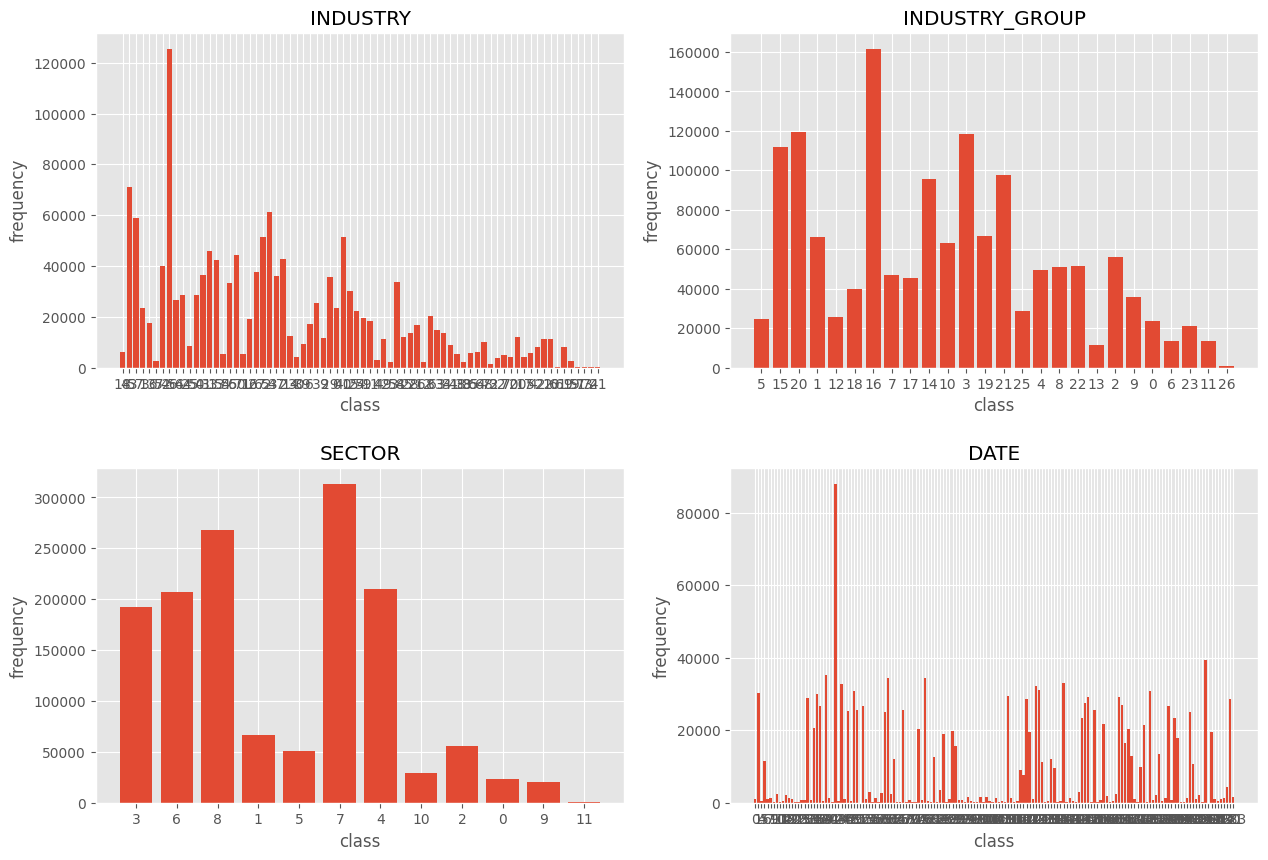

In [8]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.3)

for i, col in zip(range(1, 5), ['INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'DATE']):
    plt.subplot(2, 2, i)
    dic = {}
    for k in X_train[col].unique():
        dic[k] = sum(X_train[X_train[col] == k].isna().sum())
    plt.bar(range(len(dic)), list(dic.values()), align='center')
    plt.xticks(range(len(dic)), list(dic.keys()))
    plt.xlabel('class')
    plt.ylabel('frequency')
    plt.title(col)

plt.show()

Conclusion: We notice that the amount of NaN per category is very variable, which shows that some industries / groups are more prone to seeing NaN values than others.

However, some days seem to have a higher amount of NaN values than others. This might be because of longer public holidays where the market closes.

Let Analyze now our target. We start by binarize it first before checking if it is balanced.

In [9]:
y_train.RET = y_train.RET.astype(int)

In [10]:
round(y_train.RET.value_counts(normalize = True)*100,1)

RET
0    50.1
1    49.9
Name: proportion, dtype: float64

<Axes: xlabel='RET'>

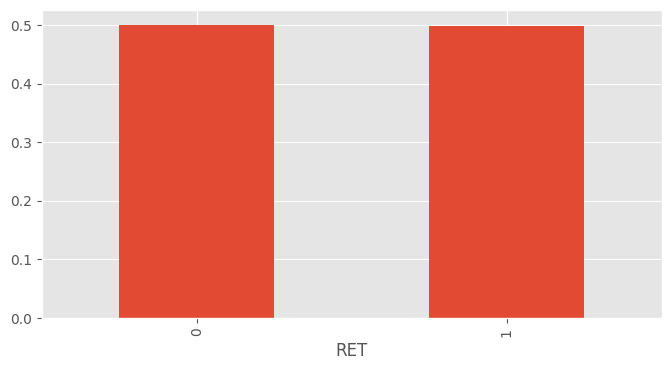

In [11]:
y_train.RET.value_counts(normalize = True).plot(kind= 'bar')

The target output seems balanced. We can therefore afford to use a conventional approach to the problem, putting inbalance-related issues aside.

Statistics

In [12]:
X_train.describe()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
count,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,416236.000000,353570.000000,416130.000000,352209.000000,...,413315.000000,351333.000000,413294.000000,356281.000000,413288.000000,351009.000000,413282.000000,351266.000000,413254.000000,350738.000000
mean,108.659002,3373.567833,37.176020,12.697959,5.483845,90.391663,0.001383,-0.071502,0.000973,-0.075230,...,0.001074,-0.076018,0.001642,-0.087854,0.001131,-0.076147,-0.000798,-0.076496,-0.000027,-0.076337
std,61.891642,1533.157749,19.706505,7.231701,2.410113,47.491157,0.031311,3.038658,0.030987,2.635549,...,0.029538,2.185741,0.031914,2.094459,0.031435,2.423121,0.030738,2.229668,0.033347,2.721355
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.845324,-2.434414,-0.770751,-3.007262,...,-0.765478,-5.600056,-0.825014,-4.610393,-0.876157,-4.167784,-0.880000,-2.341887,-0.785714,-2.768928
25%,56.000000,2478.000000,22.000000,6.000000,4.000000,49.000000,-0.010970,-0.555394,-0.011312,-0.540629,...,-0.010527,-0.533574,-0.011331,-0.552613,-0.010949,-0.539491,-0.012139,-0.527846,-0.011682,-0.542790
50%,104.000000,3560.000000,43.000000,15.000000,6.000000,104.000000,0.000637,-0.282609,0.000401,-0.278437,...,0.000530,-0.272271,0.000433,-0.285480,0.000000,-0.281753,0.000000,-0.277674,0.000000,-0.283405
75%,161.000000,4606.000000,53.000000,19.000000,7.000000,128.000000,0.012950,0.047759,0.012326,0.041177,...,0.012084,0.029131,0.012862,0.027272,0.012180,0.027639,0.011236,0.030201,0.011712,0.035795
max,223.000000,5716.000000,74.000000,26.000000,11.000000,182.000000,1.444990,1232.174009,1.427746,632.268279,...,1.028902,355.613431,1.707736,408.771698,6.000004,788.461460,2.954430,631.249564,7.208859,932.939205


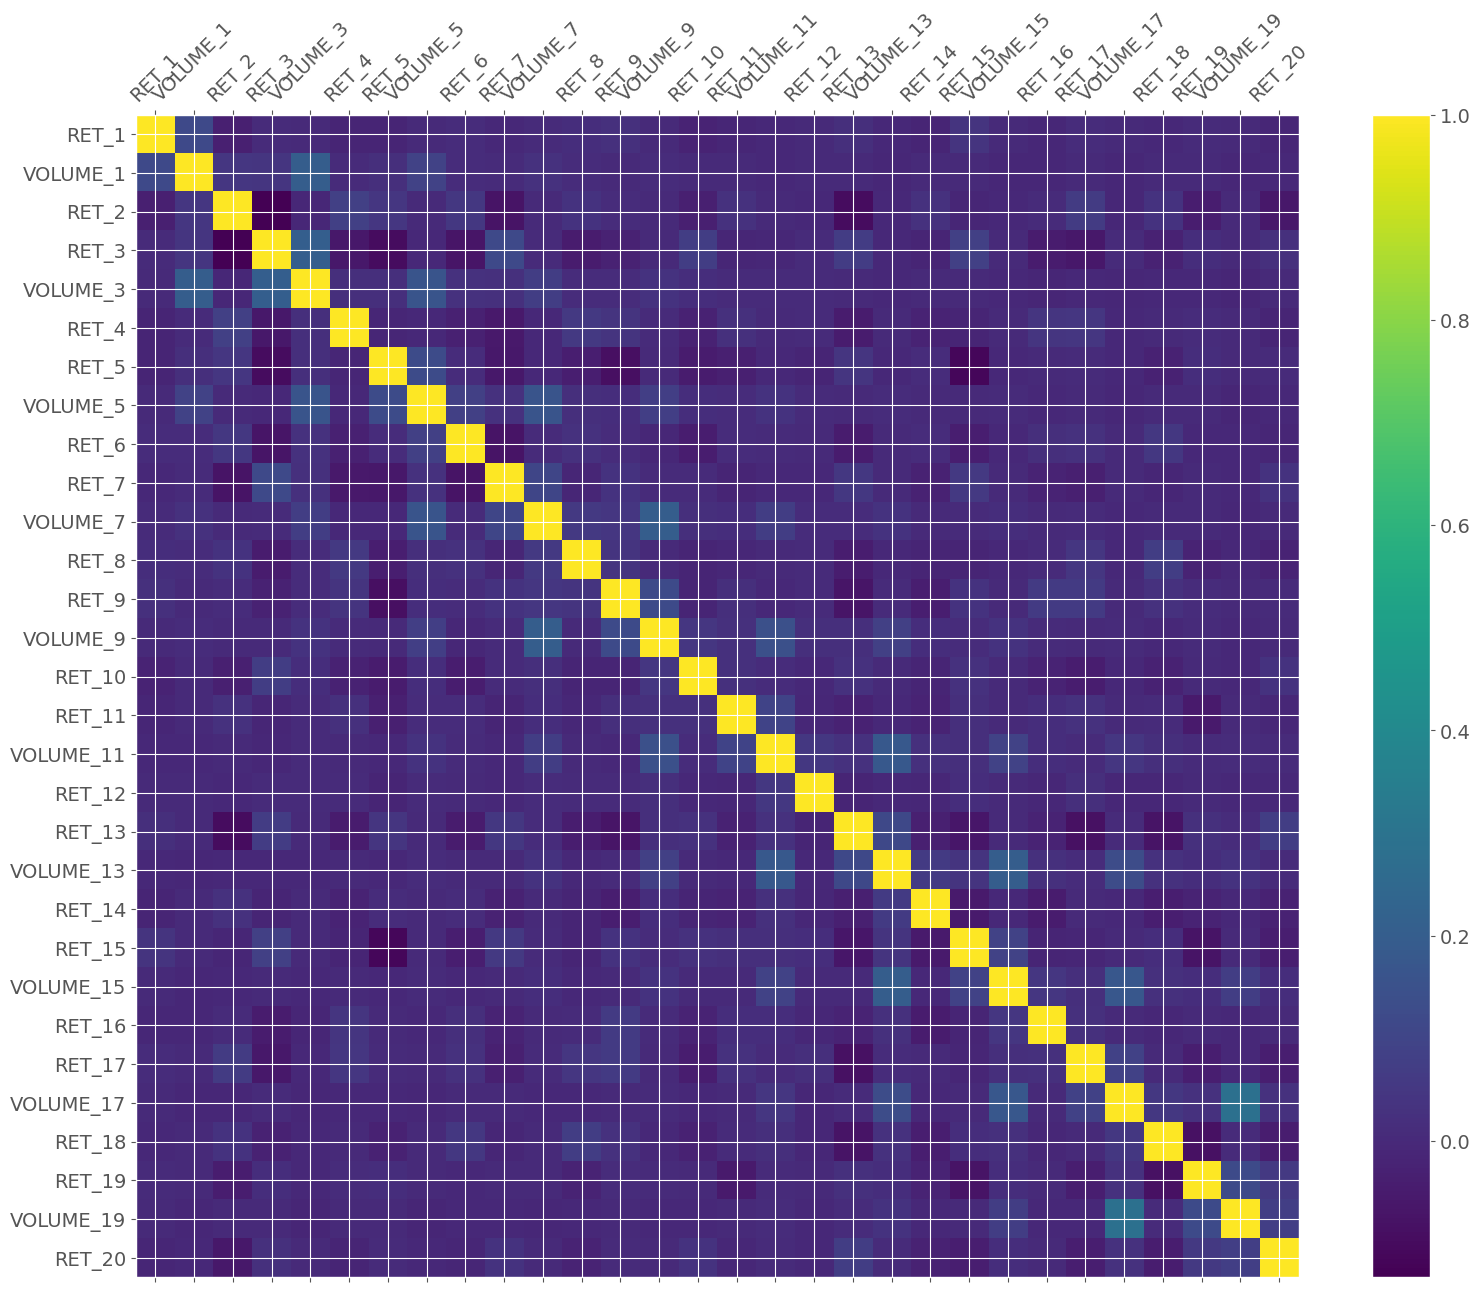

In [13]:
to_drop = ['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR','SUB_INDUSTRY']

for col in ['VOLUME_' + str(i) for i in range(2, 21, 2)]:
    to_drop += [col]

fig = plt.figure(figsize = (19, 15))
plt.matshow(X_train.drop(to_drop, axis = 1).corr(), fignum = fig.number)
plt.xticks(range(X_train.drop(to_drop, axis = 1).shape[1]), X_train.drop(to_drop, axis = 1).columns, fontsize = 14, rotation = 45)
plt.yticks(range(X_train.drop(to_drop, axis = 1).shape[1]), X_train.drop(to_drop, axis = 1).columns, fontsize = 14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize = 14)
plt.show()

Conclusion: There seem to be no outlier or surprising values. We can therefore assume that apart from the NaN issue, the dataset requires minimum cleaning. 
Moreover, all the features seem to be linearly uncorrelated, so no conclusion can be made at this point.

##### 3. Data Cleaning and Models


##### 3.1 Data Cleaning

**Dealing with the NaN values**

As mentionned before, the VOLUME columns are showing the relative volume. One way to overcome the NaN values could be to recompute these using the nan-median function from the numpy library, as this function computes the median over a period ignoring the NaN values.
However, to do this, we'd need to know the total trade volume among the 20 stocks at a time step t, which we don't have.

Let's visualize where the NaN values are located on one of the VOLUME columns: An easy way would be to fill the NaN values with an absurd number and see the outliers on the chart.

<Axes: xlabel='ID'>

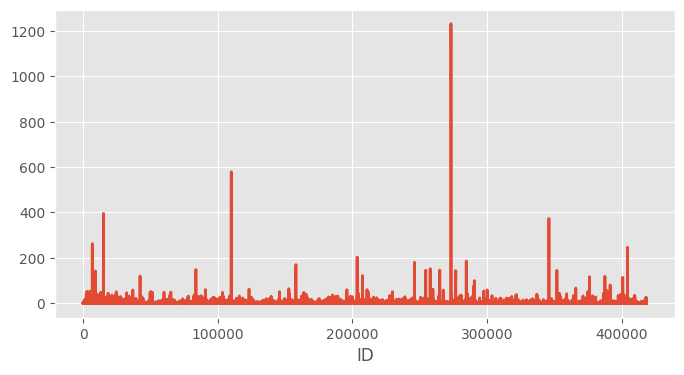

In [14]:
X_train['VOLUME_1'].fillna(value = 0).plot()

<Axes: xlabel='ID'>

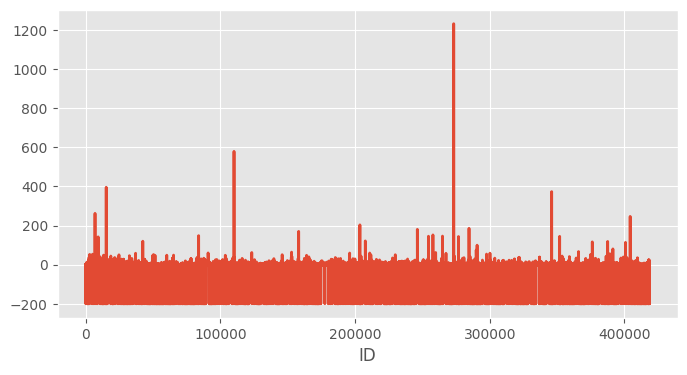

In [15]:
X_train['VOLUME_1'].fillna(value = -200).plot()

<Axes: xlabel='ID'>

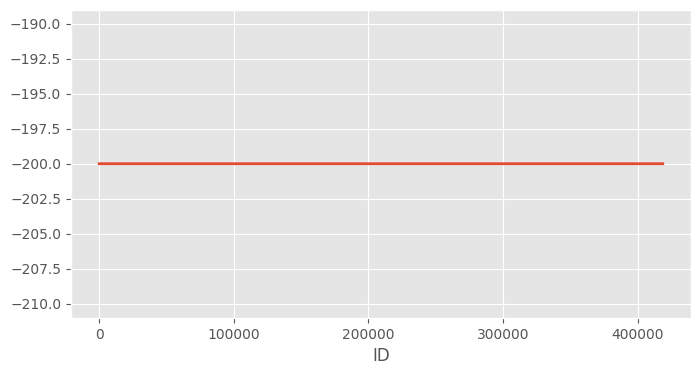

In [16]:
X_train['VOLUME_1'].fillna(value = -200)[X_train['VOLUME_1'].fillna(value = -200) < -100].plot()

We conclude that the NaN values appear pretty much constantly and randomly throughout the whole dataset.

In [17]:
X_train['VOLUME_1'].mean()

-0.0715015760424831

In [18]:
X_train['VOLUME_1'].std()

3.0386579280309625

Seeing that the mean is -0.07(near to 0) and the std is 3.04( no too much so tha we can say there are extreme values in the dataset),  So we can suppose that the following methods could be a good fit for filling the NaNs without bringing too much error in the dataset:

. Fill the NaN values with 0 (near to the mean)

. Fill the NaN values with the mean (either rolling or over the whole colum)

. Interpolate every NaN with the closest non NaN values (although not optimal if there are too many consecutive NaNs)

Let's use the average.

In [19]:
for column in X_train:
    X_train[column] = X_train[column].fillna(X_train[column].mean())

In [20]:
X_train.isna().sum()

DATE              0
STOCK             0
INDUSTRY          0
INDUSTRY_GROUP    0
SECTOR            0
SUB_INDUSTRY      0
RET_1             0
VOLUME_1          0
RET_2             0
VOLUME_2          0
RET_3             0
VOLUME_3          0
RET_4             0
VOLUME_4          0
RET_5             0
VOLUME_5          0
RET_6             0
VOLUME_6          0
RET_7             0
VOLUME_7          0
RET_8             0
VOLUME_8          0
RET_9             0
VOLUME_9          0
RET_10            0
VOLUME_10         0
RET_11            0
VOLUME_11         0
RET_12            0
VOLUME_12         0
RET_13            0
VOLUME_13         0
RET_14            0
VOLUME_14         0
RET_15            0
VOLUME_15         0
RET_16            0
VOLUME_16         0
RET_17            0
VOLUME_17         0
RET_18            0
VOLUME_18         0
RET_19            0
VOLUME_19         0
RET_20            0
VOLUME_20         0
dtype: int64

**Features Engineering**

The main drawback in this challenge would be to deal with the noise. To do that, we could create some feature that aggregate features with some statistics.

Tech1: **Weekly average and standard deviation for return** 

Under the assumption that 1 week = 5 days, the following code computes the weeklyu average and standard deviation of the past two weeks

In [21]:
new_features_dic = {}

for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('RET_' + str(week * 5 + day))
    new_features_dic['AVG_RET_WEEK' + str(week + 1)] = X_train[features].mean(axis=1)
    
new_features = pd.DataFrame(new_features_dic)
new_features.head()

,AVG_RET_WEEK1,AVG_RET_WEEK2,AVG_RET_WEEK3,AVG_RET_WEEK4
ID,,,,
0,-0.003694,0.059023,-0.001328,0.011270
1,-0.026274,0.038943,-0.022391,-0.012566
2,-0.006658,0.010191,-0.000870,-0.006835
3,0.003658,-0.011622,0.005285,-0.009936
4,0.002059,-0.002470,0.002895,-0.016689


In [22]:
new_features_dic = {}

for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('RET_' + str(week * 5 + day))
    new_features_dic['STD_RET_WEEK' + str(week + 1)] = X_train[features].std(axis=1)
    
new_features = pd.concat((new_features, pd.DataFrame(new_features_dic)), axis=1)
new_features.head()

,AVG_RET_WEEK1,AVG_RET_WEEK2,AVG_RET_WEEK3,AVG_RET_WEEK4,STD_RET_WEEK1,STD_RET_WEEK2,STD_RET_WEEK3,STD_RET_WEEK4
ID,,,,,,,,
0,-0.003694,0.059023,-0.001328,0.011270,0.016027,0.093068,0.035702,0.028107
1,-0.026274,0.038943,-0.022391,-0.012566,0.042498,0.072515,0.019070,0.021442
2,-0.006658,0.010191,-0.000870,-0.006835,0.031757,0.031354,0.016597,0.009919
3,0.003658,-0.011622,0.005285,-0.009936,0.018668,0.022146,0.011372,0.028261
4,0.002059,-0.002470,0.002895,-0.016689,0.026294,0.021603,0.054073,0.022074


In [23]:
new_features_dic = {}
for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    new_features_dic['AVG_VOL_WEEK' + str(week + 1)] = X_train[features].mean(axis=1).abs()

new_features = pd.concat((new_features, pd.DataFrame(new_features_dic)), axis=1)
new_features.head()

,AVG_RET_WEEK1,AVG_RET_WEEK2,AVG_RET_WEEK3,AVG_RET_WEEK4,STD_RET_WEEK1,STD_RET_WEEK2,STD_RET_WEEK3,STD_RET_WEEK4,AVG_VOL_WEEK1,AVG_VOL_WEEK2,AVG_VOL_WEEK3,AVG_VOL_WEEK4
ID,,,,,,,,,,,,
0,-0.003694,0.059023,-0.001328,0.011270,0.016027,0.093068,0.035702,0.028107,0.194968,2.721878,0.760344,0.062895
1,-0.026274,0.038943,-0.022391,-0.012566,0.042498,0.072515,0.019070,0.021442,0.085021,0.091055,0.079773,0.078571
2,-0.006658,0.010191,-0.000870,-0.006835,0.031757,0.031354,0.016597,0.009919,0.075251,0.236733,0.216767,0.309817
3,0.003658,-0.011622,0.005285,-0.009936,0.018668,0.022146,0.011372,0.028261,0.596365,0.256153,0.876580,0.427098
4,0.002059,-0.002470,0.002895,-0.016689,0.026294,0.021603,0.054073,0.022074,1.097822,0.635516,3.913261,0.245354


In [24]:
new_features_dic = {}
for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    new_features_dic['STD_VOL_WEEK' + str(week + 1)] = X_train[features].std(axis=1)

new_features = pd.concat((new_features, pd.DataFrame(new_features_dic)), axis=1)
new_features.head()

,AVG_RET_WEEK1,AVG_RET_WEEK2,AVG_RET_WEEK3,AVG_RET_WEEK4,STD_RET_WEEK1,STD_RET_WEEK2,STD_RET_WEEK3,STD_RET_WEEK4,AVG_VOL_WEEK1,AVG_VOL_WEEK2,AVG_VOL_WEEK3,AVG_VOL_WEEK4,STD_VOL_WEEK1,STD_VOL_WEEK2,STD_VOL_WEEK3,STD_VOL_WEEK4
ID,,,,,,,,,,,,,,,,
0,-0.003694,0.059023,-0.001328,0.011270,0.016027,0.093068,0.035702,0.028107,0.194968,2.721878,0.760344,0.062895,0.485623,3.506872,0.750430,0.375799
1,-0.026274,0.038943,-0.022391,-0.012566,0.042498,0.072515,0.019070,0.021442,0.085021,0.091055,0.079773,0.078571,0.011118,0.006062,0.005748,0.005193
2,-0.006658,0.010191,-0.000870,-0.006835,0.031757,0.031354,0.016597,0.009919,0.075251,0.236733,0.216767,0.309817,0.166250,0.468279,0.124713,0.185567
3,0.003658,-0.011622,0.005285,-0.009936,0.018668,0.022146,0.011372,0.028261,0.596365,0.256153,0.876580,0.427098,0.348658,0.530622,0.728515,0.286219
4,0.002059,-0.002470,0.002895,-0.016689,0.026294,0.021603,0.054073,0.022074,1.097822,0.635516,3.913261,0.245354,0.194741,0.414731,8.385123,0.440387


In [25]:
new_features.shape

(418595, 16)

tech2: **Regrouping the features by SECTOR / DATE**

In [26]:
# Merging the new features to train
new_train = pd.concat((X_train, new_features), axis=1)

# Feature engineering
new_features_list = []

# Conditional aggregated features: Average return over each SECTOR / DATE
shifts = [1,2,3,4]
statistics = ['mean']
gb_features = ['SECTOR', 'DATE']
target_feature = 'RET_'
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}{shift}'
        new_features_list.append(name)
        new_train[name] = new_train.groupby(gb_features)[feat].transform(stat)

# Conditional aggregated features: Percentage of volume of each SECTOR / DATE group over the total
shifts = [1,2,3,4]
statistics = ['sum']
gb_features = ['SECTOR', 'DATE']
target_feature = 'AVG_VOL_WEEK'
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}{shift}'
        new_features_list.append(name)
        new_train[name] = new_train[feat] / new_train.groupby(gb_features)[feat].transform(stat)

In [27]:
new_features_list += new_features.columns.to_list()

In [28]:
new_features_list

['RET_1_SECTOR_DATE_mean',
 'RET_2_SECTOR_DATE_mean',
 'RET_3_SECTOR_DATE_mean',
 'RET_4_SECTOR_DATE_mean',
 'AVG_VOL_WEEK1_SECTOR_DATE_sum',
 'AVG_VOL_WEEK2_SECTOR_DATE_sum',
 'AVG_VOL_WEEK3_SECTOR_DATE_sum',
 'AVG_VOL_WEEK4_SECTOR_DATE_sum',
 'AVG_RET_WEEK1',
 'AVG_RET_WEEK2',
 'AVG_RET_WEEK3',
 'AVG_RET_WEEK4',
 'STD_RET_WEEK1',
 'STD_RET_WEEK2',
 'STD_RET_WEEK3',
 'STD_RET_WEEK4',
 'AVG_VOL_WEEK1',
 'AVG_VOL_WEEK2',
 'AVG_VOL_WEEK3',
 'AVG_VOL_WEEK4',
 'STD_VOL_WEEK1',
 'STD_VOL_WEEK2',
 'STD_VOL_WEEK3',
 'STD_VOL_WEEK4']

In [29]:
new_train.shape

(418595, 70)

**Features Selection**

To reduce the number of feature (and **the noise**) we can consider ways to reduce the number of features:

. Keep the 5 last days of RET and VOLUME in addition to the newly created feature.

. OR/AND remove one of the features that are highly correlated

.OR perform a PCA to keep most of the information in less variables

In [30]:
n_shifts = 5  # If you don't want all the shifts to reduce noise
features = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
features += new_features_list  # The conditional features
new_train[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,...,STD_RET_WEEK3,STD_RET_WEEK4,AVG_VOL_WEEK1,AVG_VOL_WEEK2,AVG_VOL_WEEK3,AVG_VOL_WEEK4,STD_VOL_WEEK1,STD_VOL_WEEK2,STD_VOL_WEEK3,STD_VOL_WEEK4
ID,,,,,,,,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.147931,0.179183,0.033832,-0.362868,-0.972920,...,0.035702,0.028107,0.194968,2.721878,0.760344,0.062895,0.485623,3.506872,0.750430,0.375799
1,0.003984,-0.090580,0.018826,-0.025540,-0.038062,-0.071502,-0.075230,-0.097235,-0.088976,-0.092163,...,0.019070,0.021442,0.085021,0.091055,0.079773,0.078571,0.011118,0.006062,0.005748,0.005193
2,0.000440,-0.058896,-0.009042,0.024852,0.009354,-0.096282,0.084771,-0.298777,-0.157421,0.091455,...,0.016597,0.009919,0.075251,0.236733,0.216767,0.309817,0.166250,0.468279,0.124713,0.185567
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,-0.429540,-0.089919,-0.639737,-0.940163,-0.882464,...,0.011372,0.028261,0.596365,0.256153,0.876580,0.427098,0.348658,0.530622,0.728515,0.286219
4,0.027273,-0.039302,0.000000,0.000000,0.022321,-0.847155,-0.943033,-1.180629,-1.313896,-1.204398,...,0.054073,0.022074,1.097822,0.635516,3.913261,0.245354,0.194741,0.414731,8.385123,0.440387


In [31]:
new_train[features].shape

(418595, 34)

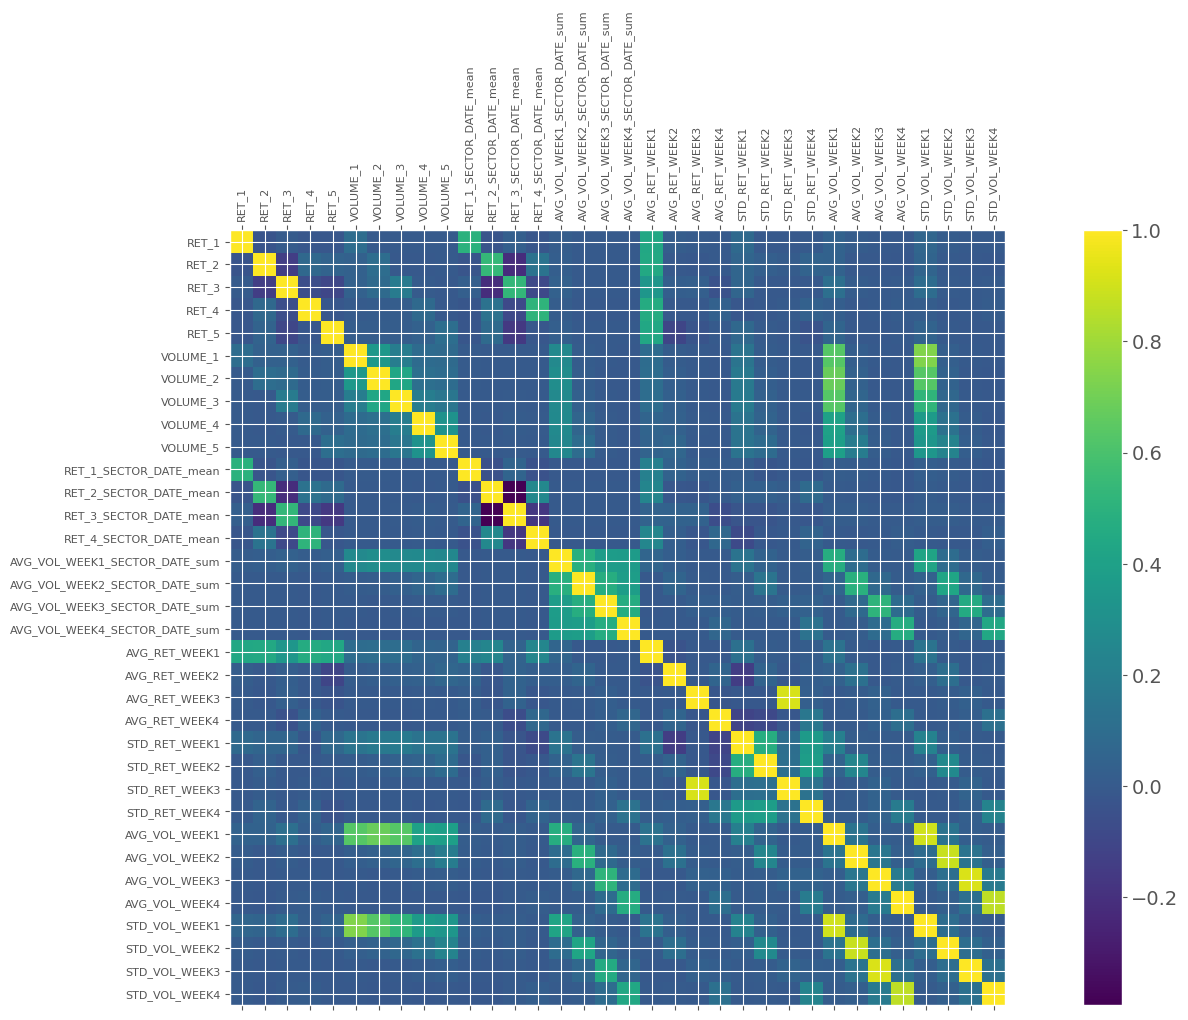

In [32]:
fig = plt.figure(figsize=(20, 10))

plt.matshow(new_train[features].corr(), fignum = fig.number)
plt.xticks(range(new_train[features].shape[1]), new_train[features].columns, fontsize = 8, rotation = 90)
plt.yticks(range(new_train[features].shape[1]), new_train[features].columns, fontsize = 8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [33]:
new_train[features].corr()[new_train[features].corr() > 0.90]

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,...,STD_RET_WEEK3,STD_RET_WEEK4,AVG_VOL_WEEK1,AVG_VOL_WEEK2,AVG_VOL_WEEK3,AVG_VOL_WEEK4,STD_VOL_WEEK1,STD_VOL_WEEK2,STD_VOL_WEEK3,STD_VOL_WEEK4
RET_1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RET_2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RET_3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RET_4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RET_5,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VOLUME_1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VOLUME_2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VOLUME_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VOLUME_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VOLUME_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The correlation seem below 0.9 for nearly all features, except for some values on week 3

3.2 **Models**

model1: **Random Forest**

We consider a large number of tree with a quiet small to prevent **overfitting** depth. A KFold is done on the dates (using DATE) for a local scoring of the model.

In [34]:
train = new_train[features]


In [37]:
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

train_dates = X_train['DATE'].unique()
test_dates = X_test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = X_train['DATE'].isin(local_train_dates)
    local_test_ids = X_train['DATE'].isin(local_test_dates)

    X_local_train = train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = X_train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 52.42%
Fold 2 - Accuracy: 50.60%
Fold 3 - Accuracy: 51.13%
Fold 4 - Accuracy: 51.88%
Accuracy: 51.51% [50.81 ; 52.20] (+- 0.70)


In [38]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns = new_train[features].columns)

<Axes: >

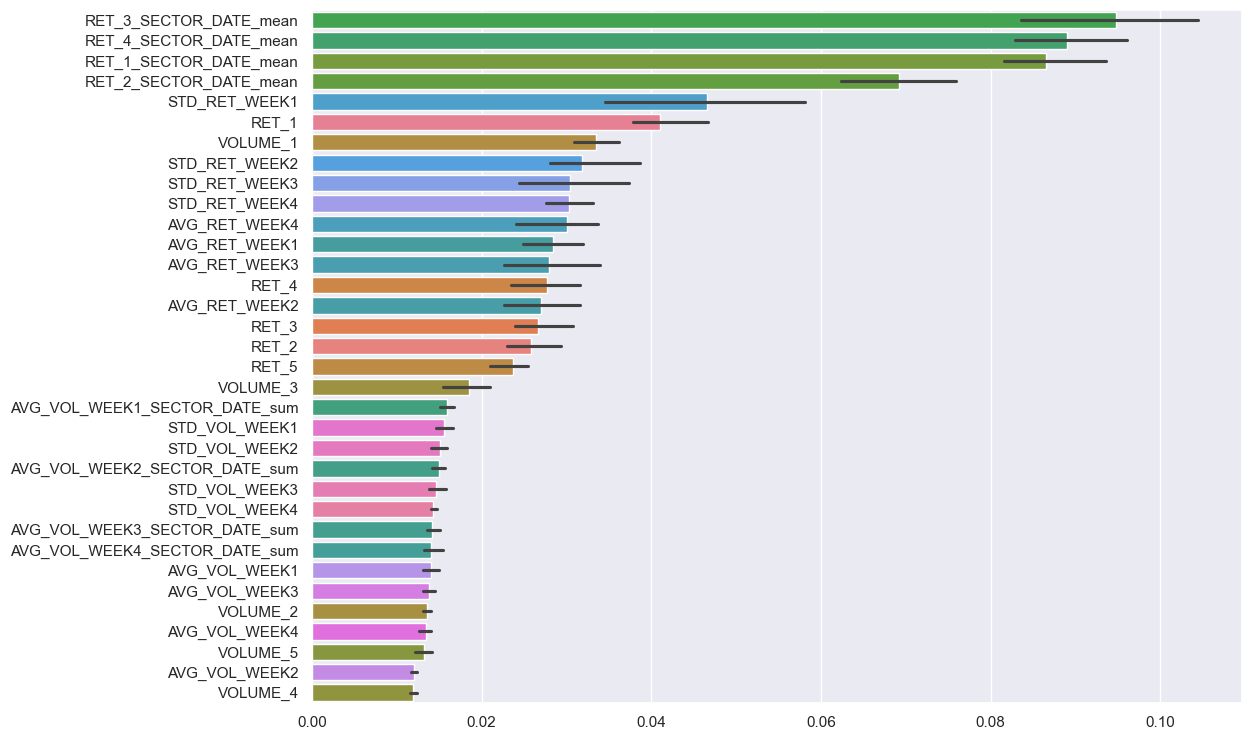

In [40]:
sns.set(rc={'figure.figsize':(12,9)})
sns.barplot(data = feature_importances, orient='h', order = feature_importances.mean().sort_values(ascending = False).index.to_list())

As it is a challenge let generate a submission

**Generate the submission**

The same parameters of the RF model are considered. With that we build a new RF model on the entire train dataset. The predictions are saved in a .csv file.

In [42]:
# Add the AVG_RET_WEEK features
new_features_dic = {}
for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('RET_' + str(week * 5 + day))
    new_features_dic['AVG_RET_WEEK' + str(week + 1)] = X_test[features].mean(axis=1)
    
new_features = pd.DataFrame(new_features_dic)

# Add the STD_RET_WEEK features
new_features_dic = {}
for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('RET_' + str(week * 5 + day))
    new_features_dic['STD_RET_WEEK' + str(week + 1)] = X_test[features].std(axis=1)
    
new_features = pd.concat((new_features, pd.DataFrame(new_features_dic)), axis=1)

# Add the AVG_VOL_WEEK features
new_features_dic = {}
for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    new_features_dic['AVG_VOL_WEEK' + str(week + 1)] = X_test[features].mean(axis=1).abs()

new_features = pd.concat((new_features, pd.DataFrame(new_features_dic)), axis=1)

# Add the STD_VOL_WEEK features
new_features_dic = {}
for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    new_features_dic['STD_VOL_WEEK' + str(week + 1)] = X_test[features].std(axis=1)

new_features = pd.concat((new_features, pd.DataFrame(new_features_dic)), axis=1)
    
# Merge the new features to train
new_test = pd.concat((X_test, new_features), axis=1)

# Feature engineering
new_features_list = []

# Conditional aggregated features: Average return over each SECTOR / DATE
shifts = [1,2,3,4]
statistics = ['mean']
gb_features = ['SECTOR', 'DATE']
target_feature = 'RET_'
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}{shift}'
        new_features_list.append(name)
        new_test[name] = new_test.groupby(gb_features)[feat].transform(stat)

# Conditional aggregated features: Percentage of volume of each SECTOR / DATE group over the total
shifts = [1,2,3,4]
statistics = ['sum']
gb_features = ['SECTOR', 'DATE']
target_feature = 'AVG_VOL_WEEK'
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}{shift}'
        new_features_list.append(name)
        new_test[name] = new_test[feat] / new_test.groupby(gb_features)[feat].transform(stat)

new_features_list += new_features.columns.to_list()

n_shifts = 5  # If you don't want all the shifts to reduce noise
features = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
features += new_features_list  # The conditional features

new_test[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,...,STD_RET_WEEK3,STD_RET_WEEK4,AVG_VOL_WEEK1,AVG_VOL_WEEK2,AVG_VOL_WEEK3,AVG_VOL_WEEK4,STD_VOL_WEEK1,STD_VOL_WEEK2,STD_VOL_WEEK3,STD_VOL_WEEK4
ID,,,,,,,,,,,,,,,,,,,,,
418595,0.020208,0.010059,0.002192,0.001903,0.001466,0.146176,0.224756,-0.474404,0.026316,0.079495,...,0.007645,0.011190,0.000468,0.165889,0.316436,0.178251,0.275660,0.086488,0.243159,0.181370
418596,0.009134,0.021913,-0.007251,-0.017223,-0.019126,-0.251631,-0.712515,-0.328719,-0.921532,-0.857393,...,0.025084,0.003894,0.614358,0.417433,0.005741,0.339664,0.306683,0.512848,0.989235,0.425939
418597,0.005008,0.005914,-0.003927,0.000873,-0.086193,-0.115845,-0.107441,0.347900,0.731513,2.681007,...,0.004404,0.005855,0.707427,0.208218,0.033058,0.308358,1.158301,0.174638,0.287544,0.221479
418598,0.015370,-0.013738,0.008600,0.001915,0.008691,-0.090295,0.048465,-0.218245,-0.055296,0.257485,...,0.009485,0.019462,0.011577,0.050427,0.497355,0.048371,0.178058,0.807225,0.209205,0.389515
418599,0.011419,0.022807,0.014645,-0.047796,-0.010220,-0.289027,-0.262690,-0.370676,-0.107222,-0.412849,...,0.011474,0.014723,0.288493,0.579163,0.534344,0.010729,0.118051,0.242568,0.218905,0.644090


In [45]:
test = new_test[features]

rf_params['random_state'] = 0
model = RandomForestClassifier(**rf_params)
model.fit(train.fillna(0), y_train)
y_pred = model.predict_proba(test.fillna(0))[:, 1]

sub = X_test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = X_test.index
submission.name = 'target'

submission.to_csv('./benchmark_qrt.csv', index=True, header=True)

Iwhen I submit in the public rank I obtain the score of 52%. 
The benchmark score can be found at https://challengedata.ens.fr. It is 51.31 %.